# "Pump it Up: Data Mining the Water Table"

EDA

Jason & Tom

In [1]:
# Imports

import pandas as pd
import numpy as np

# Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Chi Square
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Test Train Split
from sklearn.model_selection import train_test_split

# Feature normalisation
from sklearn.preprocessing import StandardScaler

# Models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier

# Model Selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report

# Balancing the dataset.
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

# Class Weight
from sklearn.utils.class_weight import compute_sample_weight

import wandb

import pickle

/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 2.0.1-elementary11-ubuntu6.1.1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


# EDA

This notebook explains the steps we took while performing EDA on our cleaned dataset. Whilst EDA does technically include 'data cleaning', we took the initiative to place that in it's own notebook so that the steps we took are much clearer. This notebook will present our findings on the correlation between certain features, as well as feature selection / engineering.

We both took different steps to do this, and collated our findings at the end. Cells by one author only will contain ``` Written By [Author] ``` at the top. Cells without this tag were steps taken by both of us, unless specified.

In [2]:
df = pd.read_csv("./datasets/cleaned_water.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)

# 1 Feature Engineering

In [3]:
# From here: https://github.com/BrendaLoznik/waterpumps

df['recorded_year'] = pd.DatetimeIndex(df ['date_recorded']).year
df['age'] = df['recorded_year'] - df['construction_year']
df['age'] = df['age'].apply(lambda x: x if x < 100 else -1)
df = df.drop('recorded_year',axis=1)

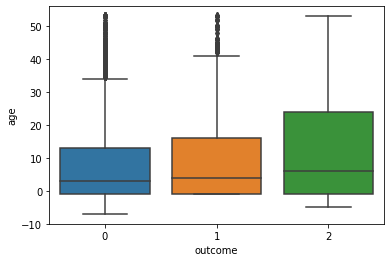

In [4]:
sns.boxplot(x='outcome', y='age', data=df)
plt.show()

In [5]:
# From here: https://github.com/BrendaLoznik/waterpumps

df['month'] = pd.DatetimeIndex(df['date_recorded']).month

# season encoder
# 1: 'short dry', 2: 'long rain', 3: 'long dry', 4: 'short rain'
season_mapper = {1: 1,2: 1, 3: 2, 4: 2, 5: 2, 6: 3, 7: 3,
                 8: 3, 9: 3, 10: 3, 11: 4, 12: 4}
#.p feature values to scale
df['season']=df['month'].replace(season_mapper)
df=df.drop('month', axis=1)

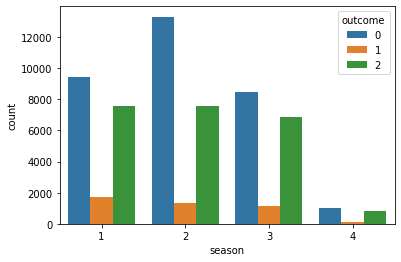

In [6]:
sns.countplot(x='season', hue='outcome', data=df)
plt.show()

In [7]:
# Author [Tom]

# quantity = 1 (enough) se to 1, everything else set to 0
df['consistent_water'] = np.where(df['quantity'] == 1, 1, 0)

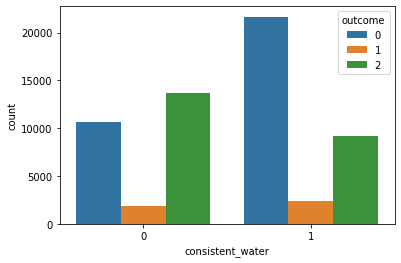

In [8]:
sns.countplot(x='consistent_water', hue='outcome', data=df)
plt.show()

In [9]:
# Author [Tom]

df['source_below_sea_level'] = np.where(df['gps_height'] < df['amount_tsh'], 1, 0)

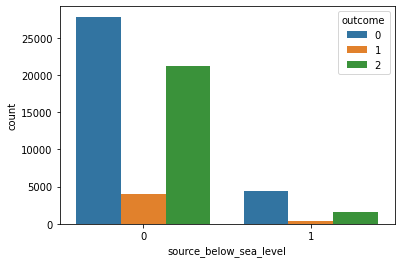

In [10]:
sns.countplot(x='source_below_sea_level', hue='outcome', data=df)
plt.show()

In [11]:
df.to_csv('./datasets/water_fe.csv')

# 2 Graphing

In [12]:
df = pd.read_csv('./datasets/water_fe.csv')
df.drop("Unnamed: 0", axis=1, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 60 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           59400 non-null  int64  
 1   amount_tsh                   59400 non-null  float64
 2   date_recorded                59400 non-null  object 
 3   funder                       55765 non-null  object 
 4   gps_height                   59400 non-null  int64  
 5   installer                    55745 non-null  object 
 6   longitude                    59400 non-null  float64
 7   latitude                     59400 non-null  float64
 8   wpt_name                     59400 non-null  object 
 9   num_private                  59400 non-null  int64  
 10  basin                        59400 non-null  int64  
 11  subvillage                   59029 non-null  object 
 12  region                       59400 non-null  object 
 13  region_code     

## 2.1 Correlation Matrix

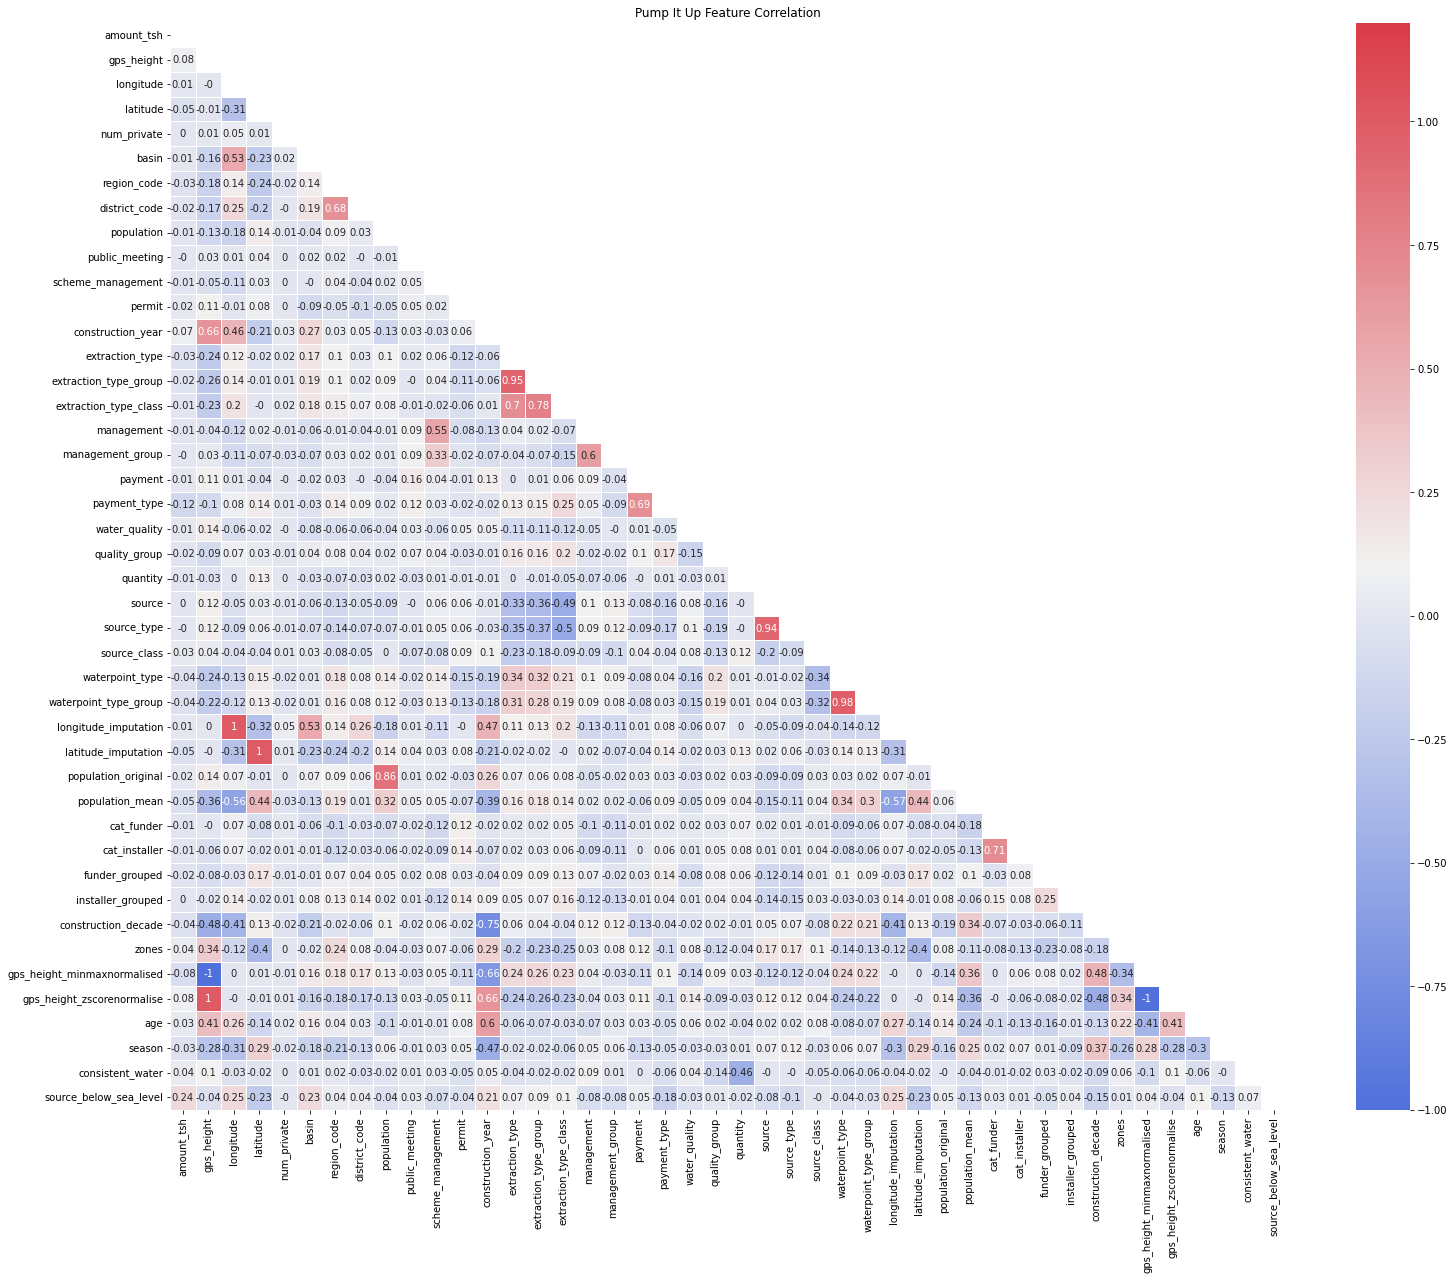

In [13]:
# Author [Jason]
# Code adapted from COMP 3009 Lab Sheet

feature = df.drop(columns=['id','outcome'])

corrMatt = feature.corr().round(2)

# Generate a mask for the upper triangle
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(25, 20))
plt.title('Pump It Up Feature Correlation')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask,
ax=ax, annot=True, fmt='.2g', linewidths=1);

There's not many super highly correlated features.

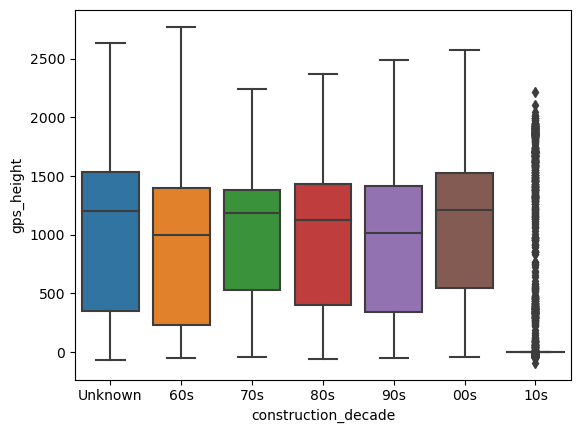

In [15]:
ax = sns.boxplot(data=df, x='construction_decade', y='gps_height')
ax.set_xticklabels(['Unknown', '60s', '70s', '80s', '90s', '00s', '10s'])
plt.show()

There doesn't seem to be a significant change in decade and gps_height.
Add more to here if we want to test out any other correlations between features.

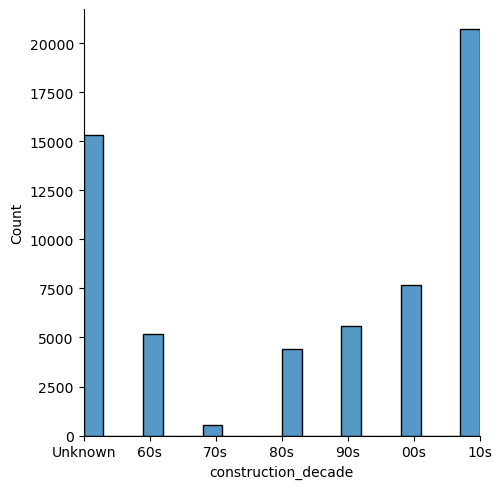

In [16]:
ax = sns.displot(data=df, x='construction_decade')
plt.xlim(0,6)
ax.set_xticklabels(['Unknown', '60s', '70s', '80s', '90s', '00s', '10s'])
plt.show()

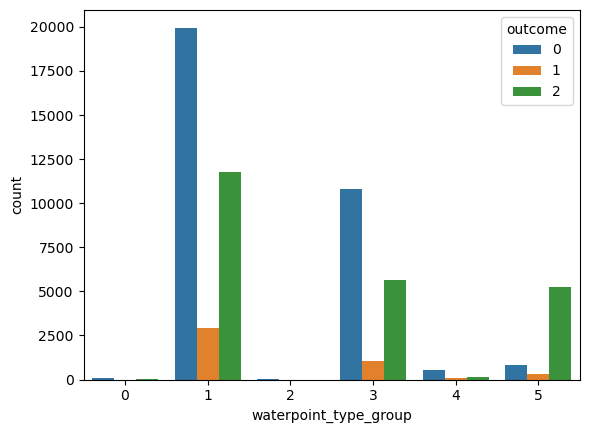

In [17]:
sns.countplot(x='waterpoint_type_group', hue='outcome', data=df)
plt.show()

Here, we can see that waterpoint_type_group 5 has a lot more of category 2, although this could be due to limited data.

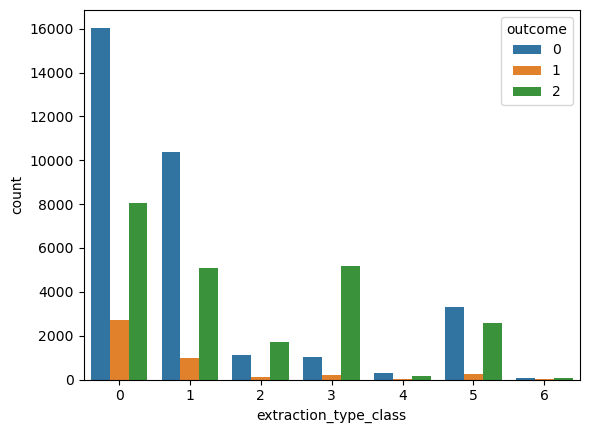

In [18]:
sns.countplot(x='extraction_type_class', hue='outcome', data=df)
plt.show()

Again, we can see that certain classes of extraction types are more likely to be of category 2.

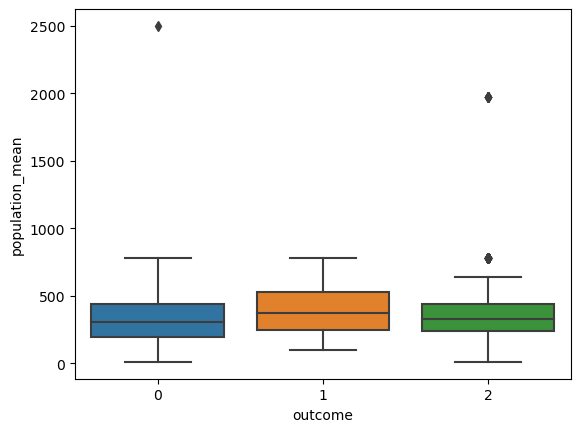

In [19]:
sns.boxplot(x='outcome', y='population_mean', data=df)
plt.show()

It's not crazy significant, but faulty wells usually have a larger population.

# 3 Feature Importance

## 3.1 Random Forest

In [14]:
# Author [Jason]
classification_target = df['outcome']

clean_feature = feature.drop(columns = ['date_recorded', 'wpt_name','num_private','subvillage','region_code','district_code','lga','ward','recorded_by',
                            'scheme_name','extraction_type_group','payment','quality_group','quantity_group',
                            'source','waterpoint_type','status_group','construction_year','region','funder','installer',
                            'installer_clean', 'funder_clean','longitude','latitude','gps_height_minmaxnormalised','gps_height_zscorenormalise','population',
                            'population_mean','cat_funder','cat_installer','consistent_water','source_below_sea_level'])

In [15]:
# Author [Jason]
X_train, X_test, y_train, y_test = train_test_split(clean_feature,classification_target, test_size=0.2, random_state=42, stratify=classification_target)
rf = RandomForestClassifier(n_estimators=64, class_weight="balanced", criterion= 'gini', max_features= 'auto')
rf.fit(X_train, y_train)

/home/tcotts/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(class_weight='balanced', max_features='auto',
                       n_estimators=64)

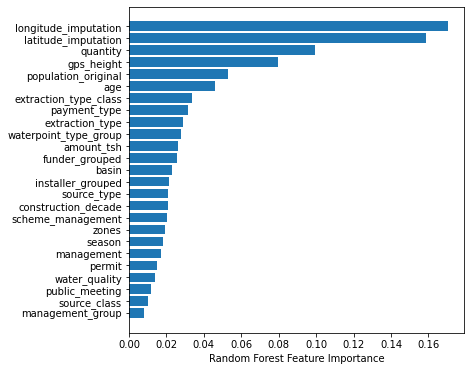

In [16]:
# Author [Jason]
sorted_idx = rf.feature_importances_.argsort()
plt.figure(figsize=(6,6))
plt.barh(clean_feature.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

## Chi Square Tests

In [17]:
# Author [Jason]
classification_target = df['outcome']
categorical_features = df[['basin','public_meeting','scheme_management','permit','extraction_type_class','management','management_group','payment_type','water_quality','quantity','source_type',
                           'source_class','waterpoint_type_group','funder_grouped','installer_grouped','construction_decade','zones']]

In [18]:
# Author [Jason]

# Select the top 10 best categorical features
categorical_features = SelectKBest(chi2, k=10).fit(categorical_features, classification_target)

# Convert the selected clinical feature's header name into a list
categorical_features_list = list(categorical_features.get_feature_names_out())
print(categorical_features_list)

['basin', 'extraction_type_class', 'management', 'payment_type', 'quantity', 'source_type', 'source_class', 'waterpoint_type_group', 'construction_decade', 'zones']


## More Feature Selection

In [19]:
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel, RFE
from time import time

In [22]:
features = df.drop(['outcome', 'funder', 'installer',
                    'wpt_name', 'subvillage', 'region',
                    'lga', 'ward', 'recorded_by', 'scheme_name',
                    'extraction_type_group', 'payment', 'quality_group',
                    'quantity_group', 'source', 'waterpoint_type',
                    'status_group', 'date_recorded', 'funder_clean', 'installer_clean'], axis=1)
target = df['outcome']

In [24]:
feature_names = features.columns
clf_xgb = XGBClassifier(random_state=42)
clf_xgb.fit(features, target)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

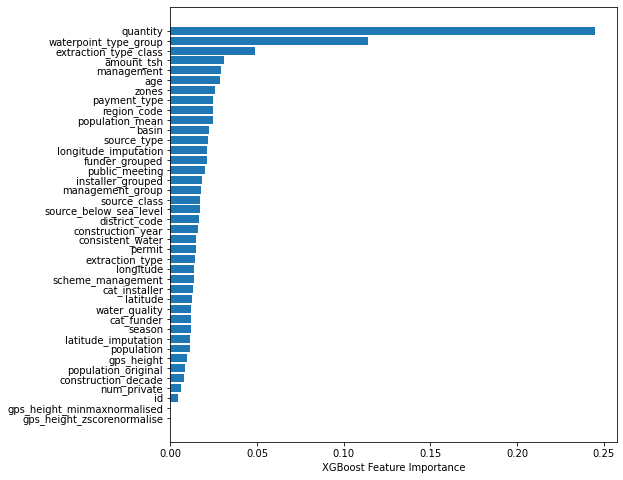

In [25]:
sorted_idx = clf_xgb.feature_importances_.argsort()
plt.figure(figsize=(8,8))
plt.barh(features.columns[sorted_idx], clf_xgb.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")
plt.show()

In [ ]:
model = SelectFromModel(clf_xgb, prefit=True)
cols_idxs = model.get_support(indices=True)
new_features = features.iloc[:, cols_idxs]
new_features

In [ ]:
# This takes too long to run ....
tic_fwd = time()
sfs_forward = SequentialFeatureSelector(
    clf_xgb, n_features_to_select='auto', direction='forward', tol=0.05
).fit(features, target)
toc_fwd = time()

print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")

tic_bwd = time()
sfs_backward = SequentialFeatureSelector(
    clf_xgb, n_features_to_select='auto', direction='backward', tol=0.05
).fit(features, target)
toc_bwd = time()

print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
)
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

In [ ]:
# This also takes a long time to run..

rfe = RFE(estimator=clf_xgb, n_features_to_select=0.75)
rfe.fit(features, target)
print(rfe.support_)
print(rfe.ranking_)

**Splitting into test/train**

In [26]:
# This is not the final feature selection, it is just the first iteration of the process.

features = df[['extraction_type', 'payment_type', 'quantity', 'source_type',
                         'waterpoint_type_group', 'cat_funder', 'construction_decade', 'consistent_water',
                         'age', 'season', 'water_quality', 'cat_installer', 'gps_height_zscorenormalise',
                         'population', 'zones','source_below_sea_level']]
target = df['outcome']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

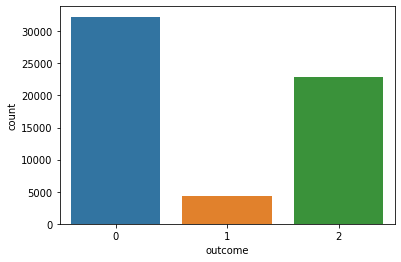

In [28]:
sns.countplot(x='outcome', data=df)
plt.show()

Imbalanced dataset unfortunately, we will have to deal with this.

# Modelling

### Model Overview

In [29]:
models = [
    HistGradientBoostingClassifier(random_state=42),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42),
    xgb.XGBClassifier(random_state=42),
    BaggingClassifier(random_state=42),
    CatBoostClassifier(random_state=42, verbose=0)
]

names = ['HistGradientBoosting', 'KNN', 'DT', 'XGB',
         'Bagging', 'CatBoost']

acc = []
prec = []
rec = []

for model in models:
    print(model)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    acc.append(accuracy_score(y_test, preds))
    prec.append(precision_score(y_test, preds, average="macro"))
    rec.append(recall_score(y_test, preds, average="macro"))


HistGradientBoostingClassifier(random_state=42)
KNeighborsClassifier()
DecisionTreeClassifier(random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42,
              reg_alpha=None, reg_lambda=None, ...)
BaggingClassifier(random_state=42)


In [32]:
model_df = pd.DataFrame({'Model': names, 'Acc': acc, 'Precision': prec, 'Recall': rec})
model_df.sort_values('Acc', ascending=False)

,Model,Acc,Precision,Recall
5,CatBoost,0.779882,0.723913,0.609056
3,XGB,0.779125,0.728705,0.600341
0,HistGradientBoosting,0.775758,0.733996,0.597320
4,Bagging,0.773148,0.684448,0.629946
2,DT,0.742256,0.623670,0.610786
1,KNN,0.697643,0.599372,0.540756


So our best options are:

    - HistGradientBoost
    - XGB
    - Bagging
    - CatBoost

In [31]:
def run_classifier(clf, X, y,  X_test, y_test):
    scores = cross_val_score(clf, X, y, cv=5)
    print("Cross-Val")
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    print("--------------------------------------")
    clf.fit(X, y)
    preds = clf.predict(X_test)
    print("1 fit")
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds, average='macro'))
    print("Recall:", recall_score(y_test, preds, average='macro'))
    cmap = sns.diverging_palette(260, 10, as_cmap=True)
    sns.heatmap(confusion_matrix(y_test, preds), cmap=cmap, annot=True)
    plt.show()
    

### HistGradientBoost

Cross-Val
0.78 accuracy with a standard deviation of 0.00
--------------------------------------
1 fit
Accuracy: 0.7757575757575758
Precision: 0.7339955847712344
Recall: 0.5973203055833515


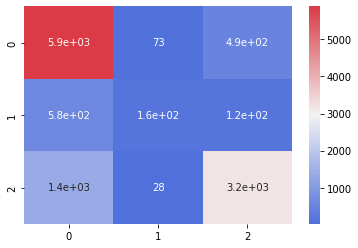

In [37]:
clf_hgb = HistGradientBoostingClassifier(random_state=42)
run_classifier(clf_hgb, X_train, y_train, X_test, y_test)

Yeh, as we can see here, it's really good at 0 <-> 0, decent at 2 <-> 2, but terrible at 1 <-> 1. Definitely needs to be balanced. When the actual class is 1, it's more likely to be predicted as 0.

The row is y_true, the column is y_pred

### XGBoost

In [30]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

Cross-Val
0.78 accuracy with a standard deviation of 0.00
--------------------------------------
1 fit
Accuracy: 0.7791245791245791
Precision: 0.7287052435332378
Recall: 0.6003407158856965


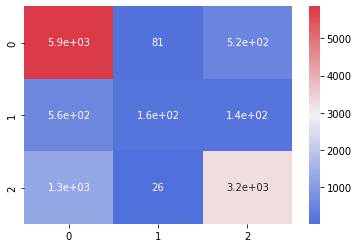

In [38]:
params = {
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric': 'merror',
    'seed': 0
}
clf_xgb = xgb.XGBClassifier(**params)

run_classifier(clf_xgb, X_train, y_train, X_test, y_test)

Accuracy: 0.7095959595959596
Precision: 0.6287181070757087
Recall: 0.6947827819531115


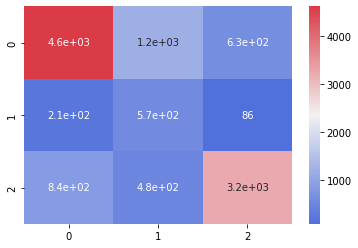

In [33]:
clf_xgb = xgb.XGBClassifier(**params)
# We are using 'class_weight' == 'balanced' here, which results in improved recall, worse accuracy.
clf_xgb.fit(X_train, y_train, sample_weight=sample_weights)
preds = clf_xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, preds))
print("Precision:", precision_score(y_test, preds, average='macro'))
print("Recall:", recall_score(y_test, preds, average='macro'))
cmap = sns.diverging_palette(260, 10, as_cmap=True)
sns.heatmap(confusion_matrix(y_test, preds), cmap=cmap, annot=True)
plt.show()

So when we balance the weights directly in XGBoost, the accuracy drops by 8%.

### CatBoost

Cross-Val
0.71 accuracy with a standard deviation of 0.01
--------------------------------------
1 fit
Accuracy: 0.7128787878787879
Precision: 0.6329387163535719
Recall: 0.7046710907663479


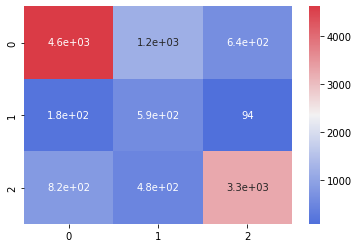

In [39]:
clf_cb = CatBoostClassifier(random_state=42, verbose=0, auto_class_weights="Balanced")
run_classifier(clf_cb, X_train, y_train, X_test, y_test)

The recall here is really good. Perhaps we can use this without balancing the dataset.

### BaggingClassifier

Cross-Val
0.77 accuracy with a standard deviation of 0.00
--------------------------------------
1 fit
Accuracy: 0.7731481481481481
Precision: 0.6844481999457512
Recall: 0.6299460301311426


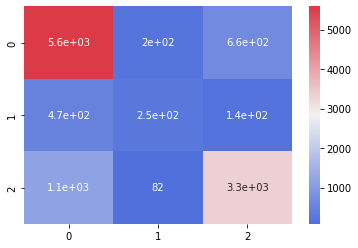

In [40]:
clf_bagging = BaggingClassifier(random_state=42)
run_classifier(clf_bagging, X_train, y_train, X_test, y_test)

## Balancing The Dataset

As we can see from the previous tests in model building, the fact that the dataset is unbalanced means we really struggle to accurately predict the 1 <-> 1 class. We can try to balance this using SMOTE-ENN. We will only rebalanced the train set, as we can then use Ensemble methods, where some models are trained on the balanced dataset and some are not.

In [19]:
sm = SMOTE(random_state=42, k_neighbors=12, sampling_strategy='minority')
enn = EditedNearestNeighbours(sampling_strategy=[1])

In [20]:
sme = SMOTEENN(random_state=42, smote=sm, enn=enn)
X_res, y_res = sme.fit_resample(X_train, y_train)

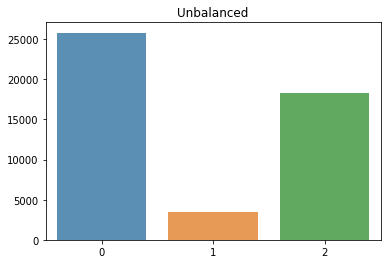

In [21]:
y_train_count = y_train.value_counts()
sns.barplot(x=y_train_count.index, y=y_train_count.values, alpha=0.8)
plt.title("Unbalanced")
plt.show()

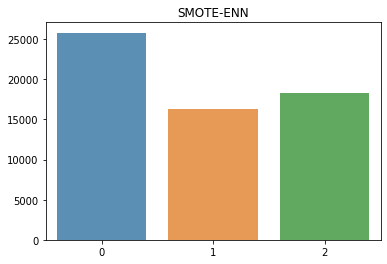

In [22]:
y_res_count = y_res.value_counts()
sns.barplot(x=y_res_count.index, y=y_res_count.values, alpha=0.8)
plt.title("SMOTE-ENN")
plt.show()

### Testing Models on the Balanced Dataset

**XGBoost**

Cross-Val
0.84 accuracy with a standard deviation of 0.02
--------------------------------------
1 fit
Accuracy: 0.7808080808080808
Precision: 0.6826653570947826
Recall: 0.6244887720500114


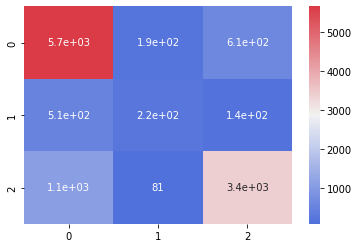

In [41]:
clf_xgb = xgb.XGBClassifier(random_state=42)
run_classifier(clf_xgb, X_res, y_res, X_test, y_test)

**CatBoost**

Cross-Val
0.81 accuracy with a standard deviation of 0.02
--------------------------------------
1 fit
Accuracy: 0.7574074074074074
Precision: 0.6431045147188654
Recall: 0.6487816015647421


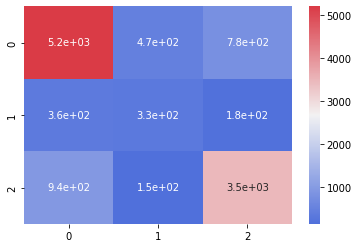

In [42]:
clf_cb = CatBoostClassifier(random_state=42, verbose=0, auto_class_weights="Balanced")
run_classifier(clf_cb, X_res, y_res, X_test, y_test)

We can set auto_class_weights to "Balanced" to increase recall but drop accuracy !

**HistGradientBoost**

Cross-Val
0.81 accuracy with a standard deviation of 0.02
--------------------------------------
1 fit
Accuracy: 0.7651515151515151
Precision: 0.6649390165348811
Recall: 0.6269602279973537


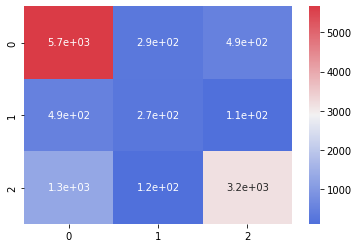

In [43]:
clf_hgb = HistGradientBoostingClassifier(random_state=42)
run_classifiersifier(clf_hgb, X_res, y_res, X_test, y_test)

**Bagging Classifier**

Cross-Val
0.82 accuracy with a standard deviation of 0.02
--------------------------------------
1 fit
Accuracy: 0.768013468013468
Precision: 0.6550489081108363
Recall: 0.6233063091489169


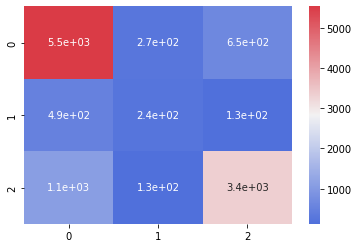

In [44]:
clf_bagging = BaggingClassifier(random_state=42)
run_classifier(clf_bagging, X_res, y_res, X_test, y_test)

## Hyper-parameter Searching

(Tom)

I will be performing hyper-parameter tuning on the (un)balanced dataset to see if we can see any improvements.

The order of tuning is:

    - Tune for 'recall_macro'
        - On Balanced Dataset
        - On UnBalanced Dataset
    - Tune for 'accuracy'
        - On Balanced Dataset
        - On UnBalanced Dataset

In [11]:
def display_results(rcv):
    print("Best Params:", rcv.best_params_)
    print("Best Estiamtor:", rcv.best_estimator_)
    print("Best Score:", rcv.best_score_)
    
    preds = rcv.best_estimator_.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds, average='macro'))
    print("Recall:", recall_score(y_test, preds, average='macro'))

    print(classification_report(y_test, preds))

    cmap = sns.diverging_palette(260, 10, as_cmap=True)
    sns.heatmap(confusion_matrix(y_test, preds), cmap=cmap, annot=True)
    plt.show()

### Tuning on the Balanced Dataset

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

In [43]:
def run_random_cv(estimator, hps, scoring, X, y):
    random_cv = RandomizedSearchCV(estimator=estimator,
                                   param_distributions=hps,
                                   cv=3, n_iter=25,
                                   scoring=scoring,
                                   verbose=1,
                                   return_train_score=True,
                                   random_state=42)
    random_cv.fit(X, y)
    print("-----------------------------------------")
    print("Best Params:", random_cv.best_params_)
    print("Best Score:", random_cv.best_score_)
    print("-----------------------------------------")
    preds = random_cv.best_estimator_.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds, average='macro'))
    print("Recall:", recall_score(y_test, preds, average='macro'))

    print(classification_report(y_test, preds))

    cmap = sns.diverging_palette(260, 10, as_cmap=True)
    sns.heatmap(confusion_matrix(y_test, preds), cmap=cmap, annot=True)
    plt.show()
    

**XGBoost**

In [39]:
xgb_hps = {
        'max_depth': [3, 6, 9],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 1e-5, 1e-3, 1e-1, 1,1e2],
        'reg_lambda': [0, 1e-5, 1e-3, 1e-1, 1, 1e2],
        'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.3],
        'n_estimators': [50, 100, 150, 200],
        'min_child_weight': [0, 0.2, 0.4, 0.6, 0.8, 1],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.5, 0.7, 0.9, 1],
}
clf_xgb = XGBClassifier()

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'subsample': 0.8, 'reg_lambda': 1e-05, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1}
Best Score: 0.8340838798131561
-----------------------------------------
Accuracy: 0.7808080808080808
Precision: 0.6826653570947826
Recall: 0.6244887720500114
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      6452
           1       0.45      0.25      0.32       863
           2       0.82      0.75      0.78      4565

    accuracy                           0.78     11880
   macro avg       0.68      0.62      0.64     11880
weighted avg       0.77      0.78      0.77     11880



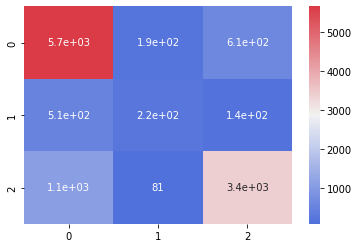

In [45]:
run_random_cv(estimator=clf_xgb, hps=xgb_hps, scoring='recall_macro', X=X_res, y=y_res)

**CatBoost**

In [40]:
cb_hps = {
    'iterations': [100, 500, 1000],
    'learning_rate': [0.03, 0.1, 0.3],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0.0, 0.5, 1.0],
    'random_strength':[0, 1, 5, 10],
    'border_count': [32, 64, 128],
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
    'verbose': [0]
}
clf_cb = CatBoostClassifier()

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'verbose': 0, 'random_strength': 10, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'iterations': 1000, 'grow_policy': 'Depthwise', 'depth': 8, 'border_count': 32, 'bagging_temperature': 1.0}
Best Score: 0.8309535182463974
-----------------------------------------
Accuracy: 0.7790404040404041
Precision: 0.6739441076323894
Recall: 0.6297609341654038
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      6452
           1       0.43      0.27      0.33       863
           2       0.81      0.76      0.78      4565

    accuracy                           0.78     11880
   macro avg       0.67      0.63      0.65     11880
weighted avg       0.77      0.78      0.77     11880



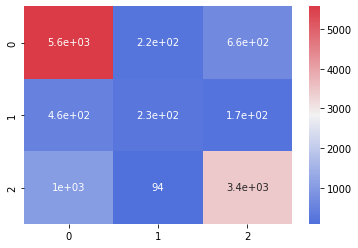

In [46]:
run_random_cv(estimator=clf_cb, hps=cb_hps, scoring='recall_macro', X=X_res, y=y_res)

**HistGradientBoost**

In [33]:
hgb_hps = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [250, 750],
    'max_depth': [2, 4, 6, 8],
    'min_samples_leaf': [1, 5, 10],
    'max_leaf_nodes': [None, 4, 8, 12],
    'l2_regularization': [0.0, 0.1, 0.5, 1.0],
    'max_bins': [64, 128, 255],
    'early_stopping': [False, 'auto'],
    'validation_fraction': [0.1, 0.2],
    'n_iter_no_change': [5, 10, 20],
}
clf_hgb = HistGradientBoostingClassifier()

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'validation_fraction': 0.1, 'n_iter_no_change': 5, 'min_samples_leaf': 5, 'max_leaf_nodes': None, 'max_iter': 750, 'max_depth': 8, 'max_bins': 255, 'learning_rate': 0.05, 'l2_regularization': 1.0, 'early_stopping': False}
Best Score: 0.832020525737014
-----------------------------------------
Accuracy: 0.7817340067340067
Precision: 0.6828387101661256
Recall: 0.6308518473945441
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      6452
           1       0.44      0.27      0.34       863
           2       0.83      0.74      0.78      4565

    accuracy                           0.78     11880
   macro avg       0.68      0.63      0.65     11880
weighted avg       0.77      0.78      0.77     11880



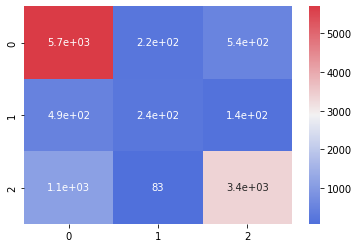

In [47]:
run_random_cv(estimator=clf_hgb, hps=hgb_hps, scoring='recall_macro', X=X_res, y=y_res)

**BaggingClassifier**

In [36]:
bc_hps = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'warm_start': [True, False],
    'n_jobs': [-1]
}
clf_bc = BaggingClassifier()

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'warm_start': True, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap_features': True, 'bootstrap': True}
Best Score: 0.8380388340328282
-----------------------------------------
Accuracy: 0.7818181818181819
Precision: 0.6796715326191115
Recall: 0.6315797894441343
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      6452
           1       0.43      0.28      0.33       863
           2       0.83      0.74      0.78      4565

    accuracy                           0.78     11880
   macro avg       0.68      0.63      0.65     11880
weighted avg       0.77      0.78      0.77     11880



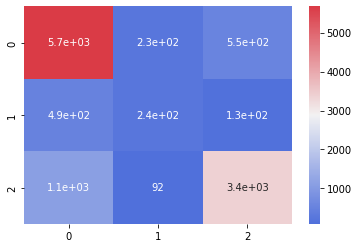

In [48]:
run_random_cv(estimator=clf_bc, hps=bc_hps, scoring='recall_macro', X=X_res, y=y_res)

### Tuning on the unbalanced dataset

**XGBoost**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'subsample': 0.8, 'reg_lambda': 1e-05, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1}
Best Score: 0.6325379115815126
-----------------------------------------
Accuracy: 0.7837542087542088
Precision: 0.69421897411529
Recall: 0.627927179037906
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      6452
           1       0.48      0.25      0.33       863
           2       0.81      0.76      0.78      4565

    accuracy                           0.78     11880
   macro avg       0.69      0.63      0.65     11880
weighted avg       0.77      0.78      0.77     11880



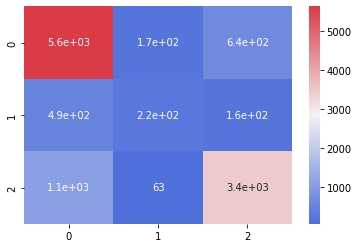

In [50]:
run_random_cv(estimator=clf_xgb, hps=xgb_hps, scoring='recall_macro', X=X_train, y=y_train)

**CatBoost**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'verbose': 0, 'random_strength': 10, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'iterations': 1000, 'grow_policy': 'Depthwise', 'depth': 8, 'border_count': 32, 'bagging_temperature': 1.0}
Best Score: 0.6353073724227817
-----------------------------------------
Accuracy: 0.7801346801346801
Precision: 0.6893581506676746
Recall: 0.6333441617531982
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      6452
           1       0.48      0.28      0.35       863
           2       0.80      0.76      0.78      4565

    accuracy                           0.78     11880
   macro avg       0.69      0.63      0.65     11880
weighted avg       0.77      0.78      0.77     11880



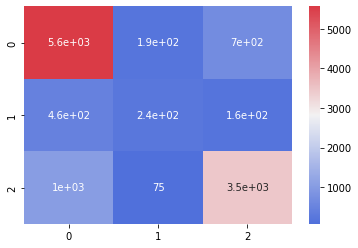

In [51]:
run_random_cv(estimator=clf_cb, hps=cb_hps, scoring='recall_macro', X=X_train, y=y_train)

**HistGradientBoost**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'validation_fraction': 0.1, 'n_iter_no_change': 5, 'min_samples_leaf': 5, 'max_leaf_nodes': None, 'max_iter': 750, 'max_depth': 8, 'max_bins': 255, 'learning_rate': 0.05, 'l2_regularization': 1.0, 'early_stopping': False}
Best Score: 0.6318738583789972
-----------------------------------------
Accuracy: 0.7867845117845118
Precision: 0.7085871939829652
Recall: 0.6311610522675023
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      6452
           1       0.52      0.26      0.35       863
           2       0.83      0.74      0.78      4565

    accuracy                           0.79     11880
   macro avg       0.71      0.63      0.65     11880
weighted avg       0.78      0.79      0.78     11880



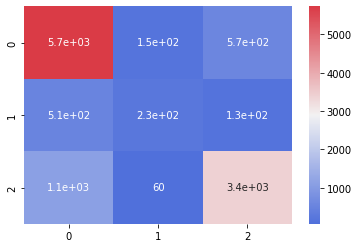

In [53]:
run_random_cv(estimator=clf_hgb, hps=hgb_hps, scoring='recall_macro', X=X_train, y=y_train)

**BaggingClassifier**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'warm_start': True, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 0.5, 'max_features': 1.0, 'bootstrap_features': False, 'bootstrap': False}
Best Score: 0.6290135314191078
-----------------------------------------
Accuracy: 0.7856902356902357
Precision: 0.6993400604935004
Recall: 0.6352661228812059
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      6452
           1       0.50      0.27      0.35       863
           2       0.81      0.76      0.78      4565

    accuracy                           0.79     11880
   macro avg       0.70      0.64      0.66     11880
weighted avg       0.78      0.79      0.78     11880



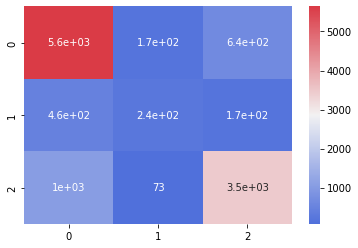

In [55]:
run_random_cv(estimator=clf_bc, hps=bc_hps, scoring='recall_macro', X=X_train, y=y_train)

### Tuning for accuracy

### Balanced Dataset

**XGBoost**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'subsample': 0.8, 'reg_lambda': 1e-05, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1}
Best Score: 0.8355404242826389
-----------------------------------------
Accuracy: 0.7808080808080808
Precision: 0.6826653570947826
Recall: 0.6244887720500114
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      6452
           1       0.45      0.25      0.32       863
           2       0.82      0.75      0.78      4565

    accuracy                           0.78     11880
   macro avg       0.68      0.62      0.64     11880
weighted avg       0.77      0.78      0.77     11880



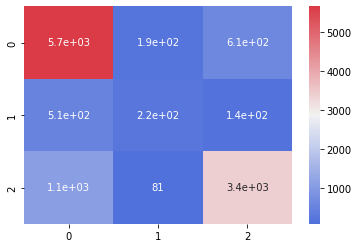

In [56]:
run_random_cv(estimator=clf_xgb, hps=xgb_hps, scoring='accuracy', X=X_res, y=y_res)

**CatBoost**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'verbose': 0, 'random_strength': 10, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'iterations': 1000, 'grow_policy': 'Depthwise', 'depth': 8, 'border_count': 32, 'bagging_temperature': 1.0}
Best Score: 0.8316341920885585
-----------------------------------------
Accuracy: 0.7790404040404041
Precision: 0.6739441076323894
Recall: 0.6297609341654038
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      6452
           1       0.43      0.27      0.33       863
           2       0.81      0.76      0.78      4565

    accuracy                           0.78     11880
   macro avg       0.67      0.63      0.65     11880
weighted avg       0.77      0.78      0.77     11880



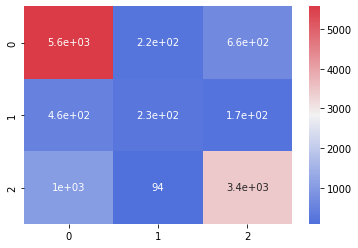

In [57]:
run_random_cv(estimator=clf_cb, hps=cb_hps, scoring='accuracy', X=X_res, y=y_res)

**HistGradientBoost**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'validation_fraction': 0.1, 'n_iter_no_change': 5, 'min_samples_leaf': 5, 'max_leaf_nodes': None, 'max_iter': 750, 'max_depth': 8, 'max_bins': 255, 'learning_rate': 0.05, 'l2_regularization': 1.0, 'early_stopping': False}
Best Score: 0.8345969655956814
-----------------------------------------
Accuracy: 0.7817340067340067
Precision: 0.6828387101661256
Recall: 0.6308518473945441
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      6452
           1       0.44      0.27      0.34       863
           2       0.83      0.74      0.78      4565

    accuracy                           0.78     11880
   macro avg       0.68      0.63      0.65     11880
weighted avg       0.77      0.78      0.77     11880



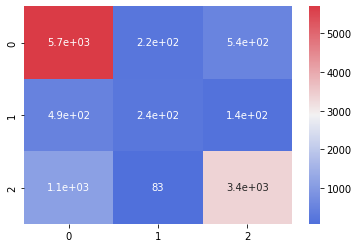

In [58]:
run_random_cv(estimator=clf_hgb, hps=hgb_hps, scoring='accuracy', X=X_res, y=y_res)

**Bagging Classifier**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'warm_start': True, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap_features': True, 'bootstrap': True}
Best Score: 0.8406714477165176
-----------------------------------------
Accuracy: 0.7815656565656566
Precision: 0.681360861035992
Recall: 0.6320939706442472
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      6452
           1       0.43      0.28      0.34       863
           2       0.83      0.74      0.78      4565

    accuracy                           0.78     11880
   macro avg       0.68      0.63      0.65     11880
weighted avg       0.77      0.78      0.77     11880



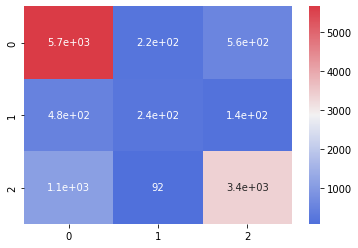

In [59]:
run_random_cv(estimator=clf_bc, hps=bc_hps, scoring='accuracy', X=X_res, y=y_res)

### Unbalanced Dataset

**XGBoost**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 1e-05, 'n_estimators': 200, 'min_child_weight': 0.6, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}
Best Score: 0.7866792929292931
-----------------------------------------
Accuracy: 0.7892255892255893
Precision: 0.7336493917050526
Recall: 0.6241879040685427
              precision    recall  f1-score   support

           0       0.77      0.90      0.83      6452
           1       0.59      0.24      0.34       863
           2       0.84      0.73      0.78      4565

    accuracy                           0.79     11880
   macro avg       0.73      0.62      0.65     11880
weighted avg       0.78      0.79      0.78     11880



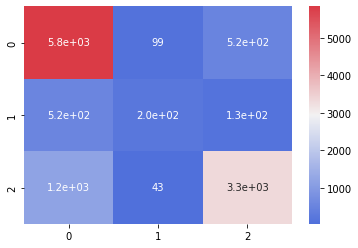

In [71]:
run_random_cv(estimator=clf_xgb, hps=xgb_hps, scoring='accuracy', X=X_train, y=y_train)

**CatBoost**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'verbose': 0, 'random_strength': 1, 'learning_rate': 0.03, 'l2_leaf_reg': 5, 'iterations': 1000, 'grow_policy': 'Depthwise', 'depth': 8, 'border_count': 32, 'bagging_temperature': 0.5}
Best Score: 0.7853114478114479
-----------------------------------------
Accuracy: 0.7884680134680134
Precision: 0.7348916711112873
Recall: 0.618063433176508
              precision    recall  f1-score   support

           0       0.77      0.90      0.83      6452
           1       0.60      0.22      0.32       863
           2       0.83      0.73      0.78      4565

    accuracy                           0.79     11880
   macro avg       0.73      0.62      0.64     11880
weighted avg       0.78      0.79      0.78     11880



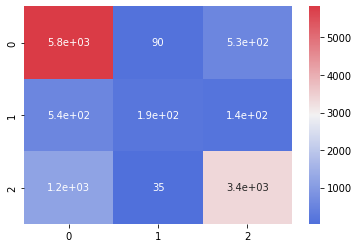

In [72]:
run_random_cv(estimator=clf_cb, hps=cb_hps, scoring='accuracy', X=X_train, y=y_train)

**HistGradientBoost**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'validation_fraction': 0.1, 'n_iter_no_change': 5, 'min_samples_leaf': 5, 'max_leaf_nodes': None, 'max_iter': 750, 'max_depth': 8, 'max_bins': 255, 'learning_rate': 0.05, 'l2_regularization': 1.0, 'early_stopping': False}
Best Score: 0.7827020202020202
-----------------------------------------
Accuracy: 0.7867845117845118
Precision: 0.7085871939829652
Recall: 0.6311610522675023
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      6452
           1       0.52      0.26      0.35       863
           2       0.83      0.74      0.78      4565

    accuracy                           0.79     11880
   macro avg       0.71      0.63      0.65     11880
weighted avg       0.78      0.79      0.78     11880



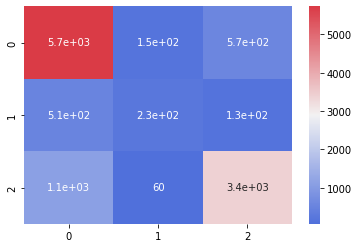

In [73]:
run_random_cv(estimator=clf_hgb, hps=hgb_hps, scoring='accuracy', X=X_train, y=y_train)

**Bagging Classifier**

Fitting 3 folds for each of 25 candidates, totalling 75 fits
-----------------------------------------
Best Params: {'warm_start': True, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 0.5, 'max_features': 1.0, 'bootstrap_features': True, 'bootstrap': False}
Best Score: 0.7870159932659933
-----------------------------------------
Accuracy: 0.7904040404040404
Precision: 0.7273118649792178
Recall: 0.6176356901931254
              precision    recall  f1-score   support

           0       0.78      0.90      0.83      6452
           1       0.57      0.21      0.31       863
           2       0.83      0.74      0.79      4565

    accuracy                           0.79     11880
   macro avg       0.73      0.62      0.64     11880
weighted avg       0.78      0.79      0.78     11880



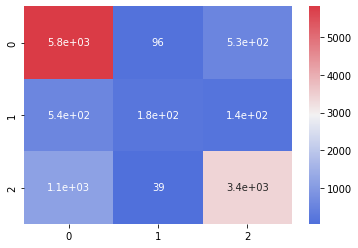

In [90]:
run_random_cv(estimator=clf_bc, hps=bc_hps, scoring='accuracy', X=X_train, y=y_train)

## Testing Features & Hyperparams

Once we have a list of possible features, and hyper-params with models. We will test out different combinations of hyperparams / ensemble models / feature lists.

In order to record each run, we will use weights & biases.

In [35]:
# This current set-up doesn't balanced the dataset, as I found there was not much need for it.

def run_wb(input_df, features, architecture, params, clf):
    wandb.init(
        project="DMA-project",
        entity="team-69",
        config={
            "features": features,
            "architecture": architecture,
            "params": params
        }
    )

    features = input_df[features]
    target = input_df['outcome']
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,
                                                        random_state=42, stratify=target)
    
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds, average='macro')
    recall = recall_score(y_test, preds, average='macro')

    wandb.log({'acc':acc, 'precision':precision, 'recall':recall})

    wandb.finish()
    
    return acc, precision, recall



In [37]:
import random

In [36]:
# Take a random subset of features

possible_features = [['quantity'], ['waterpoint_type', 'waterpoint_type_group'],
                     ['extraction_type', 'extraction_type_group', 'extraction_type_class'],
                     ['payment', 'payment_type'], ['age'],
                     [('latitude_imputation', 'longitude_imputation'), ('longitude', 'latitude')],
                     ['zones'], ['season'], ['basin'], ['source', 'source_type', 'source_class'],
                     [('cat_funder', 'cat_installer'), ('funder_grouped', 'installer_grouped')],
                     ['consistent_water', 'source_below_sea_level'],
                     ['population_mean', 'population'], ['water_quality', 'quality_group'],
                     ['construction_decade'], ['gps_height_minmaxnormalised', 'gps_height_zscorenormalise']]

def gen_features(seed, n_features=15):
    random.seed(seed)
    features = []
    for feature in possible_features:
        nf = random.choice(feature)
        if type(nf) is tuple:
            features.append(nf[0])
            features.append(nf[1])
        else:
            features.append(nf)
    
    return random.sample(features, n_features)

In [38]:
# You can change this random seed to get a completely different set of results.
# All the results will be saved on weights & biases.
# For reference, we have used these seeds so far [42]
random.seed(24)
RUNS = 20

seeds = [random.randint(0, 1000) for i in range(RUNS)]
architectures = ['XGBoost', 'CatBoost', 'HistGradBoost', 'Bagging']

# I'll take all the 'best' params from our previous HP tuning section.
xgb_params = [{'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 1e-05, 'n_estimators': 200, 'min_child_weight': 0.6, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7},
              {'subsample': 0.8, 'reg_lambda': 1e-05, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0, 'colsample_bytree': 1}]
cb_params = [{'verbose': 0, 'random_strength': 1, 'learning_rate': 0.03, 'l2_leaf_reg': 5, 'iterations': 1000, 'grow_policy': 'Depthwise', 'depth': 8, 'border_count': 32, 'bagging_temperature': 0.5},
             {'verbose': 0, 'random_strength': 10, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'iterations': 1000, 'grow_policy': 'Depthwise', 'depth': 8, 'border_count': 32, 'bagging_temperature': 1.0}]
hgb_params = [{'validation_fraction': 0.1, 'n_iter_no_change': 5, 'min_samples_leaf': 5, 'max_leaf_nodes': None, 'max_iter': 750, 'max_depth': 8, 'max_bins': 255, 'learning_rate': 0.05, 'l2_regularization': 1.0, 'early_stopping': False}]
bc_params = [{'warm_start': True, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 0.5, 'max_features': 1.0, 'bootstrap_features': True, 'bootstrap': False},
             {'warm_start': True, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap_features': True, 'bootstrap': True},
             {'warm_start': True, 'n_jobs': -1, 'n_estimators': 100, 'max_samples': 0.5, 'max_features': 1.0, 'bootstrap_features': False, 'bootstrap': False}]

base_df = pd.read_csv('./datasets/water_fe.csv')
base_df.drop("Unnamed: 0", axis=1, inplace=True)

for seed in seeds:
    features = gen_features(seed)
    architecture = random.choice(architectures)
    print(architecture)
    if architecture == 'XGBoost':
        params = random.choice(xgb_params)
        clf = XGBClassifier(**params)
        run_wb(base_df, features, architecture, params, clf)
    elif architecture == 'CatBoost':
        params = random.choice(cb_params)
        clf = CatBoostClassifier(**params)
        run_wb(base_df, features, architecture, params, clf)
    elif architecture == 'HistGradBoost':
        params = random.choice(hgb_params)
        clf = HistGradientBoostingClassifier(**params)
        run_wb(base_df, features, architecture, params, clf)
    elif architecture == 'Bagging':
        params = random.choice(bc_params)
        clf = BaggingClassifier(**params)
        run_wb(base_df, features, architecture, params, clf)
    else:
        print("If you see this, it's too late....")
    
    

Bagging


wandb: Currently logged in as: thomascotter00 (team-69). Use `wandb login --relogin` to force relogin


acc,▁
precision,▁
recall,▁
acc,0.80362
precision,0.7216
recall,0.65506


## Voting Classifier

As all of models perform similarily and neither gains a significant improvement in metrics over the other, perhaps we could combine them and see what happens?

In [40]:
from sklearn.ensemble import VotingClassifier

In [72]:
# This is based of some of the best runs on WandB.

voting_features = ['age', 'latitude_imputation', 'longitude_imputation', 'construction_decade',
                  'quality_group', 'basin', 'extraction_type', 'cat_installer', 'population',
                  'gps_height_zscorenormalise', 'cat_funder', 'quantity', 'consistent_water',
                  'source_class', 'zones', 'waterpoint_type', 'season', 'extraction_type_class',
                  'payment']

clf_cb = CatBoostClassifier(bagging_temperature=0.5, border_count=32, depth=8, grow_policy='Depthwise',
                           iterations=1000, l2_leaf_reg=5, learning_rate=0.03, random_strength=1, verbose=0)
clf_xgb = XGBClassifier(colsample_bytree=1, gamma=0, learning_rate=0.3, max_depth=9, min_child_weight=1,
                        n_estimators=200, reg_alpha=1, reg_lambda=0.00001, subsample=0.8)
clf_hgb = HistGradientBoostingClassifier(early_stopping=False, l2_regularization=1, learning_rate=0.05, max_bins=255,
                                        max_depth=8, max_iter=750, max_leaf_nodes=None, min_samples_leaf=5, n_iter_no_change=5,
                                        validation_fraction=0.1)
clf_bag = BaggingClassifier(bootstrap=True, bootstrap_features=True, max_features=1, max_samples=1, n_estimators=100,
                           n_jobs=-1, warm_start=True)

features = base_df[voting_features]
target = base_df['outcome']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
voting_clf = VotingClassifier(estimators=[('catboost',clf_cb), ('xgboost', clf_xgb), ('hgb', clf_hgb), ('Bagging', clf_bag)], voting='soft')

In [73]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x7f1783769fa0>),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0,
                                            gpu_id=None, grow_policy=None,
                                            importance_t...
                                            reg_alpha=1, reg_lambda=1e-05, ...)),
                             ('hgb',
                              HistGradientBoostingClassifier(early_stopping=False,
                                                             l2_regularization=1,
                                                             learning_rate=0.05,
                                                             max_depth=8,
                                                             max_iter=750,
                                                             max_leaf_nodes=None,
                                                             min_samples_leaf=5,
                                                             n_iter_no_change=5)),
                             ('Bagging',
                              BaggingClassifier(bootstrap_features=True,
                                                max_features=1, max_samples=1,
                                                n_estimators=100, n_jobs=-1,
                                                warm_start=True))],
                 voting='soft')

In [74]:
prob_preds = voting_clf.predict_proba(X_test)
preds = np.argmax(prob_preds, axis=1)
print("ACC:", accuracy_score(y_test, preds))
print("RECALL:", recall_score(y_test, preds, average='macro'))

ACC: 0.8115319865319865
RECALL: 0.6497119664419316


I like this one, so I will train it on the whole dataset and the test set shall be directly from drivendata.

In [75]:
voting_clf.fit(features, target)
with open("./models/voting.pickle", "wb") as f:
    pickle.dump(voting_clf, f)

If we were to train each model on slightly different subsets of the data (bagging), then we would have some variance and this would **possibly** improve our voting classifier.

To do this, we need to write our own custom classifier - which would have a list of models trained on subsets.

In [48]:
class CustomVotingClassifier():
    
    def __init__(self, estimators, bagging=True):
        """
        Args:
            estimators ([(string, Classifier)]): A list of tuples containing the label and estimator itself.
        """
        self.estimators_ = [est[1] for est in estimators]
        self.estimators = estimators
        self.bagging = bagging
    
    def fit(self, X, y):
        
        if self.bagging:
            concat_df = pd.concat([X, y], axis=1)
        
        for est in self.estimators_:
            if self.bagging:
                sampled_data = concat_df.sample(n=len(concat_df), replace=True)
                new_X = sampled_data.drop('outcome', axis=1)
                new_y = sampled_data['outcome']
                
                est.fit(new_X, new_y)
            else:
                est.fit(X, y)
    
    def predict(self, X):
        
        preds_proba = np.asarray([est.predict_proba(X) for est in self.estimators_])
        avg = np.average(preds_proba, axis=0)
        
        preds = np.argmax(avg, axis=1)
        return preds
        
                
            
            

In [49]:
custom_voting = CustomVotingClassifier(estimators=[('catboost',clf_cb), ('xgboost', clf_xgb), ('hgb', clf_hgb), ('Bagging', clf_bag)])

In [50]:
custom_voting.fit(X_train, y_train)

In [52]:
preds = custom_voting.predict(X_test)
print("ACC:", accuracy_score(y_test, preds))
print("RECALL:", recall_score(y_test, preds, average='macro'))

ACC: 0.8033670033670034
RECALL: 0.6431100671795587


### Saving the model

We can save our best model for later use.

In [53]:
import pickle

In [54]:
with open("./models/voting.pickle", "wb") as f:
    pickle.dump(voting_clf, f)

---
# Jason's Models

All Modelling done in this sections is done by Jason unless stated otherwise

In [25]:
drivers = df[['longitude_imputation','latitude_imputation','quantity','extraction_type_class','gps_height','age',
              'waterpoint_type_group','population_original','payment_type','source_type','funder_grouped',
              'basin','installer_grouped','management','water_quality','public_meeting']]

target = df['outcome']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(drivers, 
                                                    target,
                                                    test_size=0.2,
                                                    stratify=target,
                                                    random_state=42)

In [27]:
# Normalisation of features
scaler = StandardScaler()
Xs_train = scaler.fit_transform(X_train)
Xs_test = scaler.fit_transform(X_test)

## Random Forest

### Hyperparameter Tuning

In [28]:
# # Random Forest Classification model initialisation
# rf_clf = RandomForestClassifier(random_state=42)

# # Random Forest Classification model's parameter grid
# f_rf_search = GridSearchCV(rf_clf,
#                             param_grid={'random_state': [42],
#                                         'n_estimators': np.arange(64,128,8).tolist(),
#                                         'max_features': ['auto', 'sqrt', 'log2'],
#                                         'criterion' :['gini'],
#                                         'class_weight' : ['balanced']
#                                         },
#                             scoring='accuracy',
#                            verbose=3)

In [29]:
# # Run fit with all sets of parameters
# # Random Forest Classifier
# f_rf_search.fit(Xs_train, y_train)

In [30]:
# print("Best parameter for Random Forest Classification ", f_rf_search.best_params_)
# print("Accuracy: ", f_rf_search.best_score_, "\n")

### Modelling

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      6452
           1       0.55      0.28      0.37       863
           2       0.83      0.76      0.80      4565

    accuracy                           0.80     11880
   macro avg       0.72      0.64      0.67     11880
weighted avg       0.79      0.80      0.79     11880



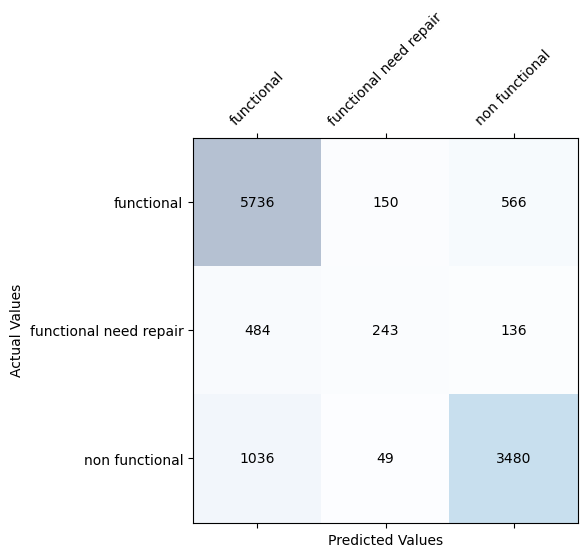

In [31]:
# Fit Random Forest Classification with the best parameter 
rf= RandomForestClassifier(class_weight= 'balanced', criterion= 'gini', max_features= 'auto', n_estimators= 64, random_state= 42)

rf.fit(Xs_train, y_train)
y_pred =rf.predict(Xs_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
        s=cm[i, j],
        va='center', ha='center')

classes=["functional","functional need repair","non functional"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

## XGBoost

In [32]:
dtrain = xgb.DMatrix(X_train, label=y_train)

In [33]:
class_weights = compute_sample_weight('balanced', y_train)

### Hyperparameter Tuning

In [34]:
# # XGBoost Classification model initialisation
# xgboost_clf = xgb.XGBClassifier(seed=42)

# # XGBoost Classification model's parameter grid
# f_xgboost_search = GridSearchCV(xgboost_clf,
#                             param_grid={'seed': [42],
#                                         'max_depth': [10,15,20,25],
#                                         'colsample_bytree': [0.75],
#                                         'subsample': [0.5],
#                                         'gamma': [0,1],
#                                         'learning_rate': [0.01,0.1],
#                                         'objective' : ['multi:softmax']
#                                         },
#                             scoring='accuracy',
#                            verbose=3)

# # Run fit with all sets of parameters
# f_xgboost_search.fit(Xs_train, y_train,sample_weight=class_weights)

In [35]:
# print("Best parameter for XGBoost Classification ", f_xgboost_search.best_params_)
# print("Accuracy: ", f_xgboost_search.best_score_, "\n")

### Modelling

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      6452
           1       0.44      0.39      0.42       863
           2       0.82      0.78      0.80      4565

    accuracy                           0.79     11880
   macro avg       0.69      0.67      0.68     11880
weighted avg       0.79      0.79      0.79     11880



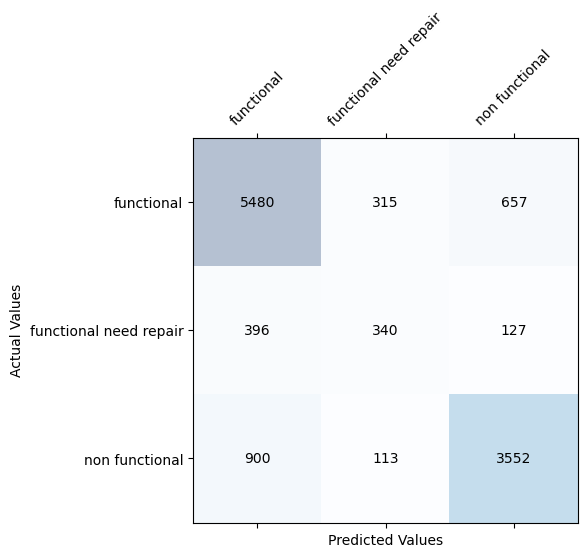

In [36]:
# Fit XGBoost Classification with the best parameter 
xgboost = xgb.XGBClassifier(colsample_bytree= 0.75, gamma= 0, learning_rate= 0.1, max_depth= 25, objective= 'multi:softmax', seed= 42, subsample= 0.5)

xgboost.fit(Xs_train, y_train,sample_weight=class_weights)
y_pred =xgboost.predict(Xs_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
        s=cm[i, j],
        va='center', ha='center')

classes=["functional","functional need repair","non functional"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

## CatBoost

### Hyperparameter Tuning

In [37]:
# catboost_clf = CatBoostClassifier(random_seed=42)

# # CatBoost Classification model's parameter grid
# f_catboost_search = GridSearchCV(catboost_clf,
#                             param_grid={'loss_function': ['MultiClass'],
#                                         'random_seed': [42],
#                                         'learning_rate': [0.01,0.1],
#                                         'depth': [4,8,12,16],
#                                         'iterations': [100]
#                                         },
#                             scoring='accuracy',
#                            verbose=3)

# # Run fit with all sets of parameters
# f_catboost_search.fit(Xs_train, y_train)

In [38]:
# print("Best parameter for CatBoost Classification ", f_catboost_search.best_params_)
# print("Accuracy: ", f_catboost_search.best_score_, "\n")

### Modelling

0:	learn: 1.0261367	total: 2.09s	remaining: 3m 27s
1:	learn: 0.9653258	total: 4.07s	remaining: 3m 19s
2:	learn: 0.9151397	total: 6.22s	remaining: 3m 21s
3:	learn: 0.8721063	total: 8.91s	remaining: 3m 33s
4:	learn: 0.8344672	total: 11.7s	remaining: 3m 41s
5:	learn: 0.8042020	total: 14.4s	remaining: 3m 45s
6:	learn: 0.7762087	total: 17.3s	remaining: 3m 49s
7:	learn: 0.7519935	total: 19.8s	remaining: 3m 47s
8:	learn: 0.7292552	total: 22.5s	remaining: 3m 47s
9:	learn: 0.7089247	total: 25.3s	remaining: 3m 47s
10:	learn: 0.6907242	total: 28.1s	remaining: 3m 47s
11:	learn: 0.6779330	total: 28.1s	remaining: 3m 26s
12:	learn: 0.6624012	total: 30.8s	remaining: 3m 26s
13:	learn: 0.6491653	total: 33.6s	remaining: 3m 26s
14:	learn: 0.6373774	total: 36.2s	remaining: 3m 25s
15:	learn: 0.6255966	total: 38.8s	remaining: 3m 23s
16:	learn: 0.6151498	total: 41.6s	remaining: 3m 22s
17:	learn: 0.6058142	total: 44.2s	remaining: 3m 21s
18:	learn: 0.5963393	total: 47s	remaining: 3m 20s
19:	learn: 0.5879383	tot

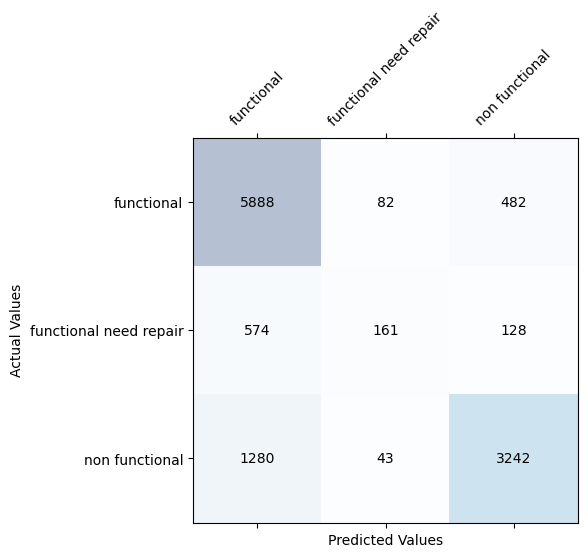

In [39]:
# Fit CatBoost Classification with the best parameter 
catboost = CatBoostClassifier(depth= 16, iterations=100, learning_rate= 0.1, loss_function= 'MultiClass', random_seed= 42)

catboost.fit(Xs_train, y_train)
y_pred =catboost.predict(Xs_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,
        s=cm[i, j],
        va='center', ha='center')

classes=["functional","functional need repair","non functional"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

print(classification_report(y_test, y_pred))

## K-Fold Cross Validation

In [40]:
models = []
models.append(("Random Forest", rf))
models.append(("XGBoost", xgboost))
models.append(("CatBoost", catboost))

# Test options and evaluation metric
num_folds = 5
num_instances = len(Xs_train)
scoring = "accuracy"
results = []
names = []

for name, model in models:
    kf = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, Xs_train, y_train, cv=kf, scoring=scoring, n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    
print("5-Fold cross-validation accuracy score for the training data for all the classifiers")

for name, cv_results in zip(names, results):
    print("%-15s: %.6f (%.6f)" % (name, cv_results.mean(), cv_results.std()))

5-Fold cross-validation accuracy score for the training data for all the classifiers
Random Forest  : 0.795560 (0.002332)
XGBoost        : 0.800021 (0.002052)
CatBoost       : 0.786742 (0.004776)


## Save Best Model With Pickle

In [41]:
# Initialise XGBoost classifier with the best parameter
xgboost_model = xgb.XGBClassifier(colsample_bytree= 0.75, gamma= 0, learning_rate= 0.1, max_depth= 25, objective= 'multi:softmax', seed= 42, subsample= 0.5)

# Normalise data
Xns = scaler.fit_transform(drivers)

# Train XGBoost classifier with the entire dataset
xgboost_model.fit(Xns, target)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.75,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=25, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [42]:
with open("./models/Jason_XGB.pickle", "wb") as f:
    pickle.dump(xgboost_model, f)